# Importing Libraries

In [1]:
import pandas as pd

from matplotlib import pyplot as plt
from pymgrid import Microgrid
from pymgrid.envs import DiscreteMicrogridEnv
from pymgrid.algos import RuleBasedControl
import gymnasium as gym
import ray
from ray.rllib.algorithms import ppo
from ray.tune.registry import register_env
from pymgrid.microgrid.utils.step import MicrogridStep

2023-10-17 09:33:11,604	WARNING deprecation.py:50 -- DeprecationWarning: `DirectStepOptimizer` has been deprecated. This will raise an error in the future!


# Initializing Ray

In [2]:
ray.init()

2023-10-17 09:33:13,419	INFO worker.py:1642 -- Started a local Ray instance.


Python version:,3.10.13
Ray version:,2.7.0


# Redefined PyMGrid Modules

## Renewable Module

In [3]:
import numpy as np
import yaml

from pymgrid.microgrid import DEFAULT_HORIZON
from pymgrid.modules.base import BaseTimeSeriesMicrogridModule


class RenewableModuleCustom(BaseTimeSeriesMicrogridModule):
    """
    A renewable energy module.

    The classic examples of renewables are photovoltaics (PV) and wind turbines.

    Parameters
    ----------
    time_series : array-like, shape (n_steps, )
        Time series of renewable production.

    forecaster : callable, float, "oracle", or None, default None.
        Function that gives a forecast n-steps ahead.

        * If ``callable``, must take as arguments ``(val_c: float, val_{c+n}: float, n: int)``, where

          * ``val_c`` is the current value in the time series: ``self.time_series[self.current_step]``

          * ``val_{c+n}`` is the value in the time series n steps in the future

          * n is the number of steps in the future at which we are forecasting.

          The output ``forecast = forecaster(val_c, val_{c+n}, n)`` must have the same sign
          as the inputs ``val_c`` and ``val_{c+n}``.

        * If ``float``, serves as a standard deviation for a mean-zero gaussian noise function
          that is added to the true value.

        * If ``"oracle"``, gives a perfect forecast.

        * If ``None``, no forecast.

    forecast_horizon : int.
        Number of steps in the future to forecast. If forecaster is None, ignored and 0 is returned.

    forecaster_increase_uncertainty : bool, default False
        Whether to increase uncertainty for farther-out dates if using a GaussianNoiseForecaster. Ignored otherwise.

    provided_energy_name: str, default "renewable_used"
        Name of the energy provided by this module, to be used in logging.

    raise_errors : bool, default False
        Whether to raise errors if bounds are exceeded in an action.
        If False, actions are clipped to the limit possible.

    """
    module_type = ('renewable', 'flex')
    yaml_tag = u"!RenewableModule"
    yaml_loader = yaml.SafeLoader
    yaml_dumper = yaml.SafeDumper

    state_components = np.array(["renewable"], dtype=object)

    def __init__(self,
                 time_series,
                 raise_errors=False,
                 forecaster=None,
                 forecast_horizon=DEFAULT_HORIZON,
                 forecaster_increase_uncertainty=False,
                 forecaster_relative_noise=False,
                 initial_step=0,
                 final_step=-1,
                 normalized_action_bounds=(0, 1),
                 provided_energy_name='renewable_used',
                 operating_cost=0.0):
        super().__init__(
            time_series,
            raise_errors,
            forecaster=forecaster,
            forecast_horizon=forecast_horizon,
            forecaster_increase_uncertainty=forecaster_increase_uncertainty,
            #forecaster_relative_noise=forecaster_relative_noise,
            initial_step=initial_step,
            final_step=final_step,
            normalized_action_bounds=normalized_action_bounds,
            provided_energy_name=provided_energy_name,
            absorbed_energy_name=None
        )
        self.operating_cost = operating_cost

    def step(self, action):
        """
        Take one step in the module, attempting to draw or send ``action`` amount of energy.

        Parameters
        ----------
        action : float or np.ndarray, shape (1,)
            The amount of energy to draw or send.

            If ``normalized``, the action is assumed to be normalized and is un-normalized into the range
            [:attr:`.BaseModule.min_act`, :attr:`.BaseModule.max_act`].

            If the **unnormalized** action is positive, the module acts as a source and provides energy to the
            microgrid. Otherwise, the module acts as a sink and absorbs energy.

            If the unnormalized action implies acting as a sink and ``is_sink`` is False -- or the converse -- an
            ``AssertionError`` is raised.

        normalized : bool, default True
            Whether ``action`` is normalized. If True, action is assumed to be normalized and is un-normalized into the
            range [:attr:`.BaseModule.min_act`, :attr:`.BaseModule.max_act`].

        Raises
        ------
        AssertionError
            If action implies acting as a source and module is not a source. Likewise if action implies acting as a
            sink and module is not a sink.

        Returns
        -------
        observation : np.ndarray
            State of the module after taking action ``action``.
        reward : float
            Reward/cost after taking the action.
        done : bool
            Whether the module terminates.
        info : dict
            Additional information from this step.
            Will include either``provided_energy`` or ``absorbed_energy`` as a key, denoting the amount of energy
            this module provided to or absorbed from the microgrid.

        """

        if action == 1:
            reward, done, info = self.update(self.max_production, as_source=True)
        else:
            reward, done, info = self.update(0, as_source=True)

        state_dict = self.state_dict()
        self._log(state_dict, reward=reward, **info)
        self._update_step()

        obs = self.to_normalized(self.state, obs=True)

        return obs, reward, done, info

    def update(self, external_energy_change, as_source=False, as_sink=False):
        assert as_source, f'Class {self.__class__.__name__} can only be used as a source.'
        assert external_energy_change <= self.current_renewable, f'Cannot provide more than {self.current_renewable}'

        info = {'provided_energy': external_energy_change,
                'curtailment': self.current_renewable-external_energy_change}

        reward = -1.0 * self.operating_cost * external_energy_change

        return reward, self._done(), info

    @property
    def max_production(self):
        return self.current_renewable

    @property
    def current_renewable(self):
        """
        Current renewable production.

        Returns
        -------
        renewable : float
            Renewable production.

        """
        return self._time_series[self._current_step].item()

    @property
    def is_source(self):
        return True

    @property
    def production_marginal_cost(self):
        return self.operating_cost

## Grid Module

In [4]:
from pymgrid.modules.grid_module import GridModule

class GridModuleCustom(GridModule):

    module_type = ('grid', 'controllable')

    yaml_tag = u"!GridModule"
    yaml_loader = yaml.SafeLoader
    yaml_dumper = yaml.SafeDumper

    state_components = np.array(['import_price', 'export_price', 'co2_per_kwh', 'grid_status'], dtype=object)

    def step(self, unbalanced_load, sold):

        if unbalanced_load > 0:
            reward, done, info = self.update(unbalanced_load, sold, as_sink=True)
        else:
            reward, done, info = self.update(-unbalanced_load, sold, as_source=True) 

        state_dict = self.state_dict()
        self._log(state_dict, reward=reward, **info)
        self._update_step()

        obs = self.to_normalized(self.state, obs=True)

        return obs, reward, done, info

    def update(self, external_energy_change, sold, as_source=False, as_sink=False):
        assert as_source + as_sink == 1, 'Must act as either source or sink but not both or neither.'
        reward_external = self.get_cost(external_energy_change, as_source, as_sink)
        reward_sold = self.get_cost(sold, False, True)
        if as_source:
            info = {"provided_energy": external_energy_change, "absorbed_energy": sold,
                'co2_production': self.get_co2_production(external_energy_change, as_source, as_sink)}
        else:
            info = {"provided_energy": 0.0, "absorbed_energy": sold + external_energy_change,
                'co2_production': self.get_co2_production(external_energy_change, as_source, as_sink)}

        return reward_external + reward_sold, self._done(), info

## Generator Module

In [5]:
from pymgrid.modules.genset_module import GensetModule

class GensetModuleDiscrete(GensetModule):

    module_type = 'genset', 'flex'
    yaml_tag = f"!Genset"
    yaml_dumper = yaml.SafeDumper
    yaml_loader = yaml.SafeLoader

    _energy_pos = 1

    def __init__(self,
                 running_min_production,
                 running_max_production,
                 genset_cost,
                 co2_per_unit=0.0,
                 cost_per_unit_co2=0.0,
                 start_up_time=0,
                 wind_down_time=0,
                 allow_abortion=True,
                 init_start_up=True,
                 initial_step=0,
                 normalized_action_bounds=(0, 1),
                 raise_errors=False,
                 provided_energy_name='genset_production',
                 num_buckets=1):

        super().__init__(running_min_production,
                         running_max_production,
                         genset_cost,
                         co2_per_unit,
                         cost_per_unit_co2,
                         start_up_time,
                         wind_down_time,
                         allow_abortion,
                         init_start_up,
                         initial_step,
                         normalized_action_bounds,
                         raise_errors,
                         provided_energy_name)

        self.increments = (self.running_max_production - self.running_min_production) / num_buckets
        self.num_buckets = num_buckets

    def step(self, action):
        """
        Take one step in the module, attempting to draw or send ``action`` amount of energy.

        Parameters
        ----------
        action : float or np.ndarray, shape (1,)
            The amount of energy to draw or send.

            If ``normalized``, the action is assumed to be normalized and is un-normalized into the range
            [:attr:`.BaseModule.min_act`, :attr:`.BaseModule.max_act`].

            If the **unnormalized** action is positive, the module acts as a source and provides energy to the
            microgrid. Otherwise, the module acts as a sink and absorbs energy.

            If the unnormalized action implies acting as a sink and ``is_sink`` is False -- or the converse -- an
            ``AssertionError`` is raised.

        normalized : bool, default True
            Whether ``action`` is normalized. If True, action is assumed to be normalized and is un-normalized into the
            range [:attr:`.BaseModule.min_act`, :attr:`.BaseModule.max_act`].

        Raises
        ------
        AssertionError
            If action implies acting as a source and module is not a source. Likewise if action implies acting as a
            sink and module is not a sink.

        Returns
        -------
        observation : np.ndarray
            State of the module after taking action ``action``.
        reward : float
            Reward/cost after taking the action.
        done : bool
            Whether the module terminates.
        info : dict
            Additional information from this step.
            Will include either``provided_energy`` or ``absorbed_energy`` as a key, denoting the amount of energy
            this module provided to or absorbed from the microgrid.

        """

        reward, done, info = self.update(action * self.increments, as_source=True)

        state_dict = self.state_dict()
        self._log(state_dict, reward=reward, **info)
        self._update_step()

        obs = self.to_normalized(self.state, obs=True)

        return obs, reward, done, info

## MicrogridStep class 

In [6]:
class MicrogridStepCustom(MicrogridStep):

    def append(self, module_name, obs, reward, done, info):
        try:
            self._obs[module_name] = obs
        except KeyError:
            self._obs[module_name] = obs
        self._reward += reward
        if done:
            self._done = True

        try:
            self._info[module_name].append(info)
        except KeyError:
            self._info[module_name] = [info]

        for key, value in info.items():
            try:
                self._info[key].append(value)
            except KeyError:
                pass

## Microgrid class

In [7]:
class Microgrid2(Microgrid):

    yaml_tag = u"!Microgrid"
    """Tag used for yaml serialization."""
    yaml_dumper = yaml.SafeDumper
    yaml_loader = yaml.SafeLoader

    def run(self, control, normalized=True):
        """

        Run the microgrid for a single step.

        Parameters
        ----------
        control : dict[str, list[float]]
            Actions to pass to each fixed module.
        normalized : bool, default True
            Whether ``control`` is a normalized value or not. If not, each module de-normalizes its respective action.

        Returns
        -------
        observation : dict[str, list[float]]
            Observations of each module after using the passed ``control``.
        reward : float
            Reward/cost of running the microgrid. A positive value implies revenue while a negative
            value is a cost.
        done : bool
            Whether the microgrid terminates.
        info : dict
            Additional information from this step.

        """
        control_copy = control.copy()
        microgrid_step = MicrogridStepCustom(reward_shaping_func=self.reward_shaping_func, cost_info=self.get_cost_info())

        for name, modules in self.fixed.iterdict():
            for module in modules:
                o, r, d, i = module.step(0.0, normalized=False)
                microgrid_step.append(name, o, r, d, i)

        fixed_provided, fixed_consumed, _, _ = microgrid_step.balance()
        log_dict = self._get_log_dict(fixed_provided, fixed_consumed, prefix='fixed')

        sold = 0.0
        for name, modules in self.flex.iterdict():
            try:
                module_controls = control_copy.pop(name)
            except KeyError:
                raise ValueError(f'Control for module "{name}" not found. Available controls:\n\t{control.keys()}')
            else:
                try:
                    _zip = zip(modules, module_controls)
                except TypeError:
                    _zip = zip(modules, [module_controls])

            for module, _control in _zip:
                module_step = module.step(_control)  # obs, reward, done, info.
                microgrid_step.append(name, module_step[0], module_step[1], module_step[2], module_step[3])
                if control_copy["status"][name] == 1:
                    sold += module_step[3]["provided_energy"]
                

        flex_fixed_provided, flex_fixed_consumed, _, _ = microgrid_step.balance()
        difference = flex_fixed_provided - flex_fixed_consumed - sold

        log_dict = self._get_log_dict(
            flex_fixed_provided-fixed_provided,
            flex_fixed_consumed-fixed_consumed,
            log_dict=log_dict,
            prefix='flex'
        )

        

        # if difference > 0, have an excess. Try to use flex sinks to dissapate
        # otherwise, insufficient. Use flex sources to make up

        for name, modules in self.controllable.iterdict():
            for module in modules:
                if name == "grid":
                    module_step = module.step(difference, sold)
                else:
                    module_step = module.step(difference)
                microgrid_step.append(name, *module_step)

        provided, consumed, reward, shaped_reward = microgrid_step.balance()

        log_dict = self._get_log_dict(
            provided-flex_fixed_provided,
            consumed-flex_fixed_consumed,
            log_dict=log_dict,
            prefix='controllable'
        )

        log_dict = self._get_log_dict(provided, consumed, log_dict=log_dict, prefix='overall')

        self._balance_logger.log(reward=reward, shaped_reward=shaped_reward, **log_dict)

        if not np.isclose(provided, consumed):
            raise RuntimeError('Microgrid modules unable to balance energy production with consumption.\n'
                               '')


        return microgrid_step.output()

    def reset(self):
        """
        Reset the microgrid and flush the log.

        Returns
        -------
        dict[str, list[float]]
            Observations from resetting the modules as well as the flushed balance log.
        """
        self._set_trajectory()
        return {
            **{module.name[0]: module.reset() for module in self.module_list},
        }


# Custom Cost Function

In [8]:
def cost_function(reward, info, cost_info):
    # Grid
    if "grid" in info:
        if "provided_energy" in info["grid"][0]:
            E_u = 0.25 * info["grid"][0]["provided_energy"]**2 * cost_info["grid"][0]["production_marginal_cost"] / 1000 +  0.5 * info["grid"][0]["provided_energy"] * cost_info["grid"][0]["production_marginal_cost"]
        else: 
            E_u = 0
        if "absorbed_energy" in info["grid"][0]:
            S_u = info["grid"][0]["absorbed_energy"] * cost_info["grid"][0]["absorption_marginal_cost"]
        else:
            S_u = 0
    else:
        E_u = 0
        S_u = 0

    # Solar
    if "solar_pv" in info:
        E_s = info["solar_pv"][0]["provided_energy"]
        C_s = cost_info["solar_pv"][0]["production_marginal_cost"]
    else:
        E_s = 0.0
        C_s = 0.0
        

    # Wind
    if "wind_turbine" in info:
        E_w = info["wind_turbine"][0]["provided_energy"]
        C_w = cost_info["wind_turbine"][0]["production_marginal_cost"]
    else:
        E_w = 0.0
        C_w = 0.0

    # Generator
    if "genset" in info:
        E_g = info["genset"][0]["provided_energy"]
        C_g = cost_info["genset"][0]["production_marginal_cost"]
    else:
        E_g = 0.0
        C_g = 0.0

    # Battery
    if "battery" in info:
        E_b = info["battery"][0]["absorbed_energy"] if "absorbed_energy" in info["battery"][0] else info["battery"][0]["provided_energy"]
        C_b = cost_info["battery"][0]["production_marginal_cost"]
    else:
        E_b = 0.0
        C_b = 0.0
    
    # Microgrid
    O_m = E_s * C_s + E_w * C_w + E_g * C_g + E_b * C_b

    reward = -(E_u + O_m - S_u) 

    return reward

# Defining the Gym Environment

In [9]:
class MicrogridEnv(gym.Env):
    def __init__(self, microgrid, action_list):
        self.action_space = gym.spaces.Discrete(len(action_list))
        self.observation_space = gym.spaces.Dict({
            module.name[0]: gym.spaces.Box(
                low=module.observation_space["normalized"].low,
                high=module.observation_space["normalized"].high,
                shape=module.observation_space["normalized"].shape,
                dtype=module.observation_space["normalized"].dtype
            )
        for module in microgrid.module_list})

        self._action_to_direction = {
            i: action for i, action in enumerate(action_list)
        }

        self.microgrid = microgrid
        
    def reset(self, seed=None, options=None):
        obs = self.microgrid.reset()
        #obs.pop("balance")
        #obs.pop("other")
        return obs, {}
        
    def step(self, action):
        action = self._action_to_direction[action]
        obs, reward, done, info = self.microgrid.run(action)
        return obs, reward, done, False, info

# Creating the Environment

## Hyperparameters

In [10]:
NUM_BUCKETS = 10

## Microgrid modules

In [11]:
from pymgrid.modules import (
    BatteryModule,
    LoadModule,
    RenewableModule,
    GridModule,
    GensetModule)

import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)

battery = BatteryModule(
    min_capacity=15,
    max_capacity=285,
    max_charge=2.5,
    max_discharge=2.5,
    efficiency=0.99,
    battery_cost_cycle=0.95,
    init_soc=0.1
)
print(battery)

gas_turbine_generator = GensetModuleDiscrete(
    running_min_production=0,
    running_max_production=600,
    genset_cost=0.55,
    num_buckets=NUM_BUCKETS
)

print(gas_turbine_generator)

data = pd.read_csv("../data/EnergyGenerationRenewable_round.csv")
time_solar = data["Solar Generation"].values
time_wind = data["Wind Generation"].values

solar_pv = RenewableModuleCustom(
    time_series=time_solar,
    operating_cost=0.15
)

print(solar_pv)

wind_turbine = RenewableModuleCustom(
    time_series=time_wind,
    operating_cost=0.085
)

print(wind_turbine)

buy_price = pd.read_csv("../data/rate_consumption_charge.csv")["Grid Elecricity Price（$/kWh）"].values
sell_price = np.ones(len(buy_price)) * .2
co2 = np.zeros(len(buy_price))

time_grid = np.concatenate([buy_price[:, None], sell_price[:, None], co2[:, None]], axis=1)

grid = GridModuleCustom(
    time_series=time_grid,
    max_export=10000,
    max_import=10000
)

time_load = pd.read_csv("../data/Load25Households.csv")["load"].values[:8640]

load = LoadModule(
    time_series=time_load
)

print(load)

modules = [
    #battery,
    #gas_turbine_generator,
    ("solar_pv", solar_pv),
    #("wind_turbine", wind_turbine),
    grid,
    load
]

BatteryModule(min_capacity=15, max_capacity=285, max_charge=2.5, max_discharge=2.5, efficiency=0.99, battery_cost_cycle=0.95, battery_transition_model=BatteryTransitionModel(), init_charge=None, init_soc=0.1, initial_step=0, normalized_action_bounds=<class 'tuple'>, raise_errors=False)
GensetModuleDiscrete(running_min_production=0, running_max_production=600, genset_cost=0.55, co2_per_unit=0.0, cost_per_unit_co2=0.0, start_up_time=0, wind_down_time=0, allow_abortion=True, init_start_up=True, initial_step=0, normalized_action_bounds=<class 'tuple'>, raise_errors=False, provided_energy_name=genset_production, num_buckets=10)
RenewableModuleCustom(time_series=<class 'numpy.ndarray'>, raise_errors=False, forecaster=NoForecaster, forecast_horizon=0, forecaster_increase_uncertainty=False, forecaster_relative_noise=False, initial_step=0, final_step=8640, normalized_action_bounds=<class 'tuple'>, provided_energy_name=renewable_used, operating_cost=0.15)
RenewableModuleCustom(time_series=<class

## Possible Actions

In [12]:
renewable = [0, 1, 0, 1]
stat = [0, 0, 1, 1]
action_list = [{"solar_pv": j, "status": {"solar_pv": m,}} for j, m in zip(renewable, stat)]

## Defining the Environment creator

In [13]:
microgrid = Microgrid2(modules=modules, add_unbalanced_module=False)
def env_creator(env_context):
    return MicrogridEnv(microgrid, action_list)  # bad code using global variables but no idea how to do it differently for now....

# Running RL

In [14]:
from ray.rllib.algorithms.dqn import DQNConfig
from ray import tune, train
from ray.tune.logger import pretty_print
from tqdm import tqdm

2023-10-17 09:33:14,128	WARNING deprecation.py:50 -- DeprecationWarning: `build_tf_policy` has been deprecated. This will raise an error in the future!
2023-10-17 09:33:14,131	WARNING deprecation.py:50 -- DeprecationWarning: `build_policy_class` has been deprecated. This will raise an error in the future!


# Evaluation

## Random

In [15]:
evaluation_grid_random = Microgrid2(modules=modules, add_unbalanced_module=False)

In [16]:
for _ in range(8640): #One year
    action = np.random.choice(action_list)
    evaluation_grid_random.run(action)

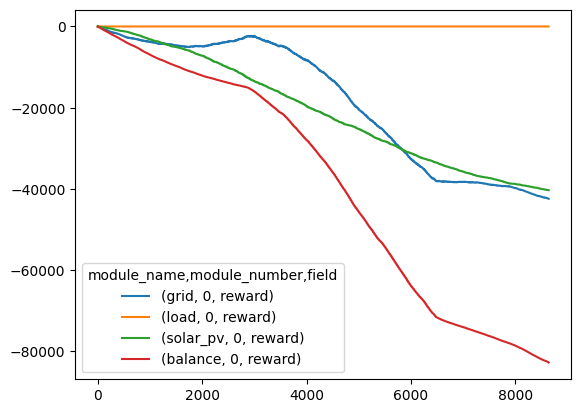

In [18]:
evaluation_grid_random.log.loc[:, pd.IndexSlice[:, :, "reward"]].cumsum().plot()
#microgrid_random.log.loc[:, pd.IndexSlice["balance", :, "shaped_reward"]].cumsum().plot()
plt.savefig("../figures/25_only_solar_random.pdf", format="pdf", bbox_inches="tight")
plt.show()

## DQN

In [19]:
#microgrid = Microgrid2(modules=modules, add_unbalanced_module=False, reward_shaping_func=cost_function)
microgrid = Microgrid2(modules=modules, add_unbalanced_module=False)
def env_creator(env_context):
    return MicrogridEnv(microgrid, action_list)  # bad code using global variables but no idea how to do it differently for now....

In [20]:
register_env("my_env", env_creator)
exploration_config = {'type': 'EpsilonGreedy',
                      'initial_epsilon': 1.0,
                      'final_epsilon': 0.0,
                      'epsilon_timesteps': 30000}
config = DQNConfig().training(gamma=0.9, lr=1e-4).exploration(explore=False, exploration_config=exploration_config).environment("my_env")
algo = config.build()
epochs = 5
for i in tqdm(range((8640//1000)*epochs)):
    result = algo.train()

2023-10-17 09:33:50,393	WARNING deprecation.py:50 -- DeprecationWarning: `rllib/algorithms/simple_q/` has been deprecated. Use `rllib_contrib/simple_q/` instead. This will raise an error in the future!
/Users/lgcharpe/Documents/the_gROKe_policy/venv/lib/python3.10/site-packages/ray/rllib/algorithms/algorithm.py:484: RayDeprecationWarning:

This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
`UnifiedLogger` will be removed in Ray 2.7.

/Users/lgcharpe/Documents/the_gROKe_policy/venv/lib/python3.10/site-packages/ray/tune/logger/unified.py:53: RayDeprecationWarning:

This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
The `JsonLogger interface is deprecated in favor of the `ray.tune.json.JsonLoggerCallback` interface and will be removed in Ray 2.7.

/Users/lgcharpe

In [21]:
env = MicrogridEnv(microgrid, action_list)

In [22]:
episode_reward = 0
obs = microgrid.reset()
terminated = False
truncated = False
actions = []
while not terminated and not truncated:
    action = algo.compute_single_action(obs)
    obs, reward, terminated, truncated, info = env.step(action)
    episode_reward += reward
    actions.append(action)

In [23]:
evaluation_grid_dqn = Microgrid2(modules=modules, add_unbalanced_module=False)

In [24]:
for ac in actions:
    evaluation_grid_dqn.run(action_list[ac])

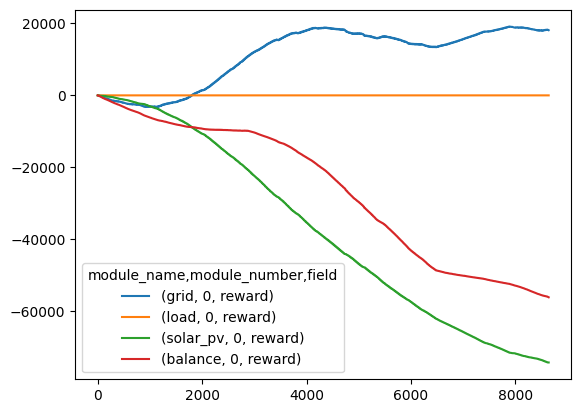

In [25]:
evaluation_grid_dqn.log.loc[:, pd.IndexSlice[:, :, "reward"]].cumsum().plot()
#microgrid_dqn.log.loc[:, pd.IndexSlice["balance", :, "shaped_reward"]].cumsum().plot()
plt.savefig("../figures/25_only_solar_dqn.pdf", format="pdf", bbox_inches="tight")
plt.show()

<Axes: >

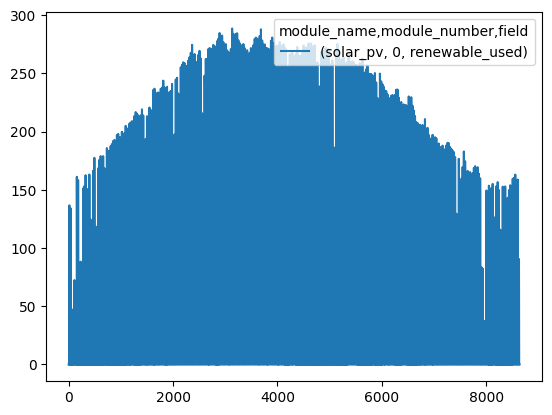

In [26]:
evaluation_grid_dqn.log.loc[:, pd.IndexSlice["solar_pv", :, "renewable_used"]].plot()

# Per month

In [27]:
days_in_month = [
    ('January', 31),
    ('February', 28),
    ('March', 31),
    ('April', 30),
    ('May', 31),
    ('June', 30),
    ('July', 31),
    ('August', 31),
    ('September', 30),
    ('October', 31),
    ('November', 30),
    ('December', 31)
]

month_start_end_dates = {days_in_month[0][0]: [0, 24 * days_in_month[0][1]]}

for month_n, (month, days_in) in enumerate(days_in_month[1:], start=1):
    last_end = month_start_end_dates[days_in_month[month_n-1][0]][-1]
    month_start_end_dates[month] = [last_end, 24 * days_in + last_end]

In [29]:
solar_status = np.array([action_list[action]["solar_pv"] for action in actions])
solar_usage = np.array([action_list[action]["status"]["solar_pv"] for action in actions])

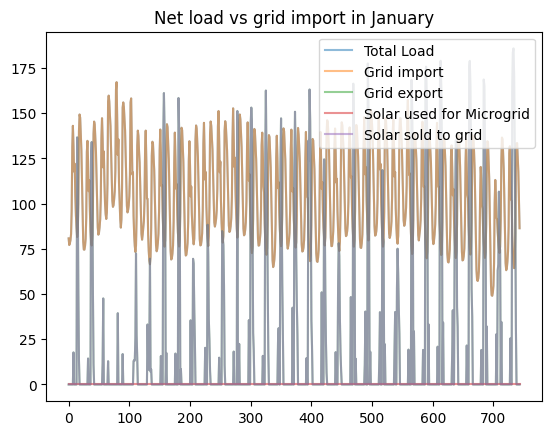

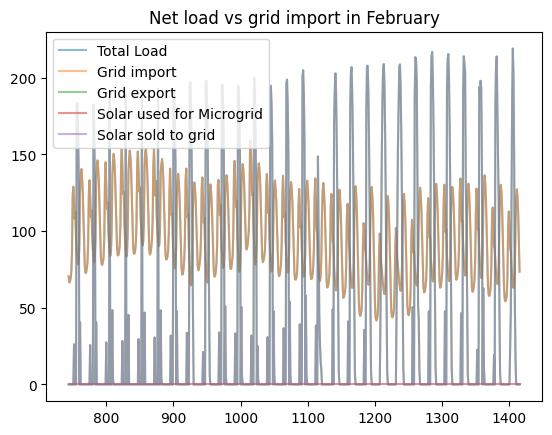

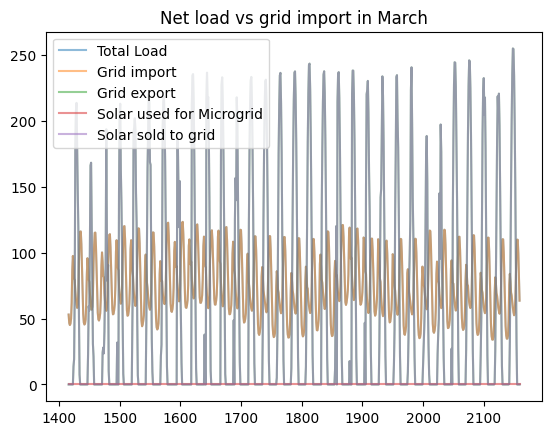

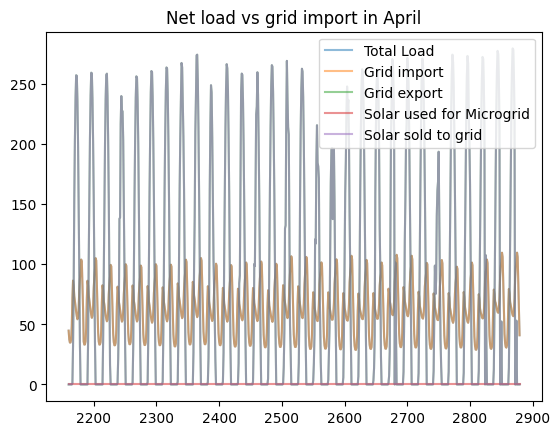

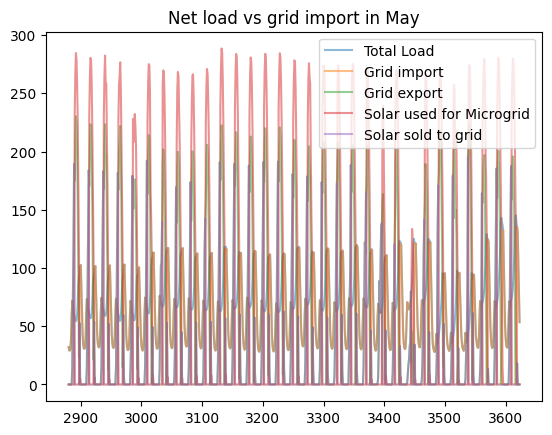

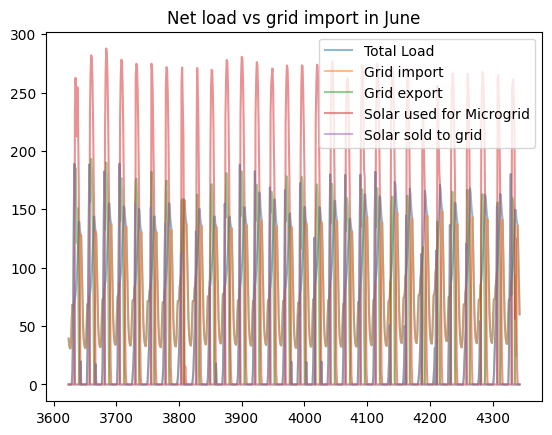

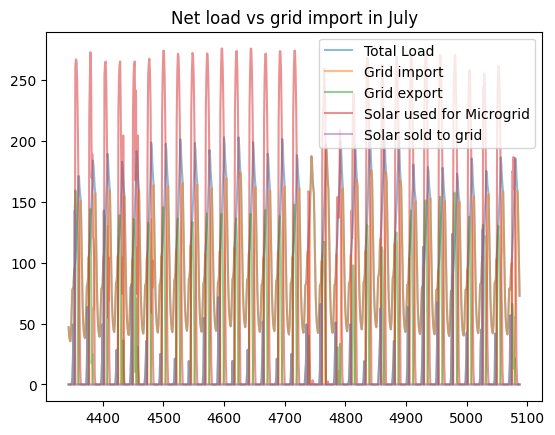

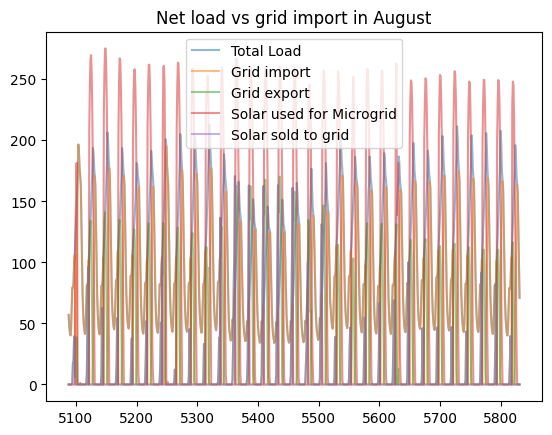

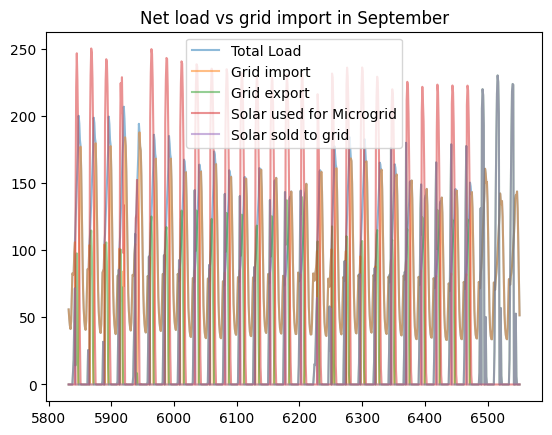

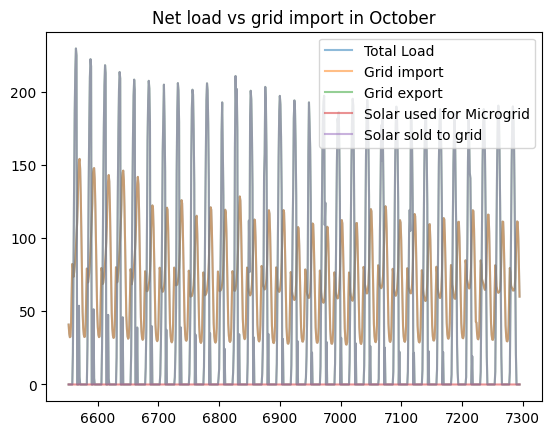

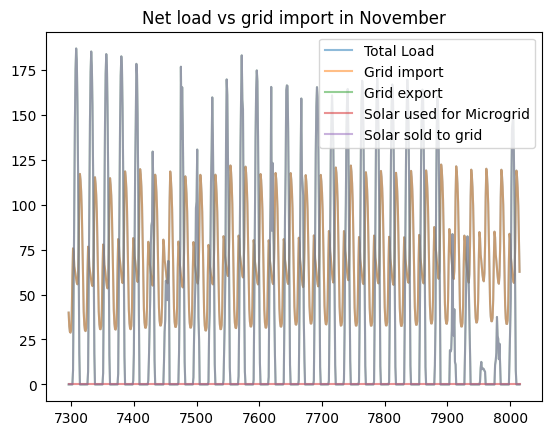

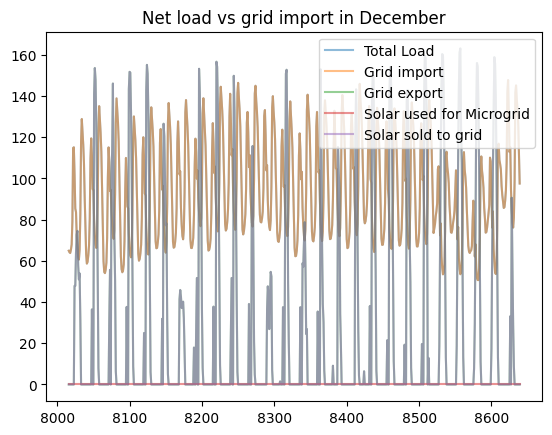

In [45]:
load = evaluation_grid_dqn.log[('load', 0, 'load_met')]
grid_import = evaluation_grid_dqn.log[('grid', 0, 'grid_import')]
grid_export = evaluation_grid_dqn.log[('grid', 0, 'grid_export')]
solar_status = pd.Series(solar_status)
solar_use = (evaluation_grid_dqn.log[('solar_pv', 0, 'renewable_used')] * (1 - solar_usage))
solar_sell = (evaluation_grid_dqn.log[('solar_pv', 0, 'renewable_used')] * (solar_usage))

for month, (start_hour, end_hour) in month_start_end_dates.items():

    pd.concat([load, grid_import, grid_export, solar_use, solar_sell],
              keys=['Total Load', 'Grid import', "Grid export", "Solar used for Microgrid", "Solar sold to grid"],
              axis=1).iloc[start_hour:end_hour].plot(alpha=0.5, title=f'Net load vs grid import in {month}')

    plt.show()

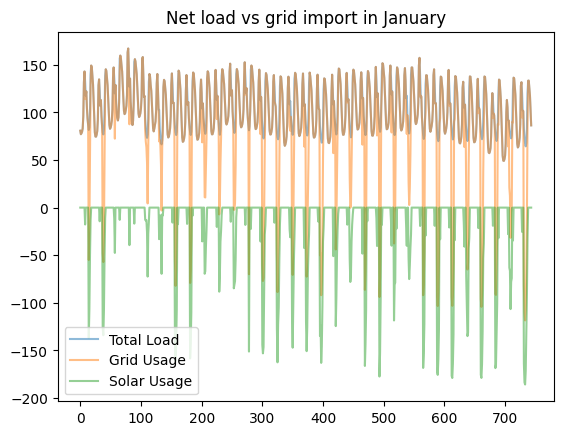

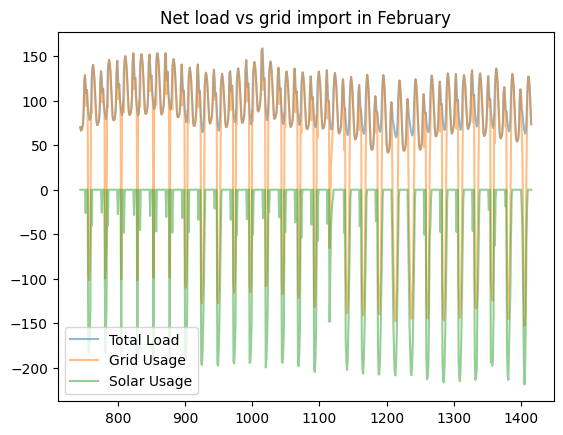

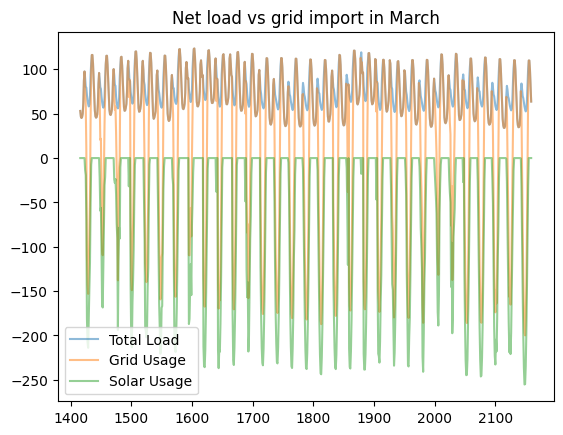

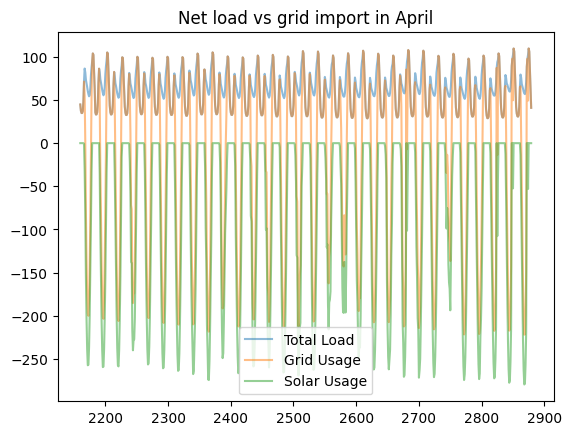

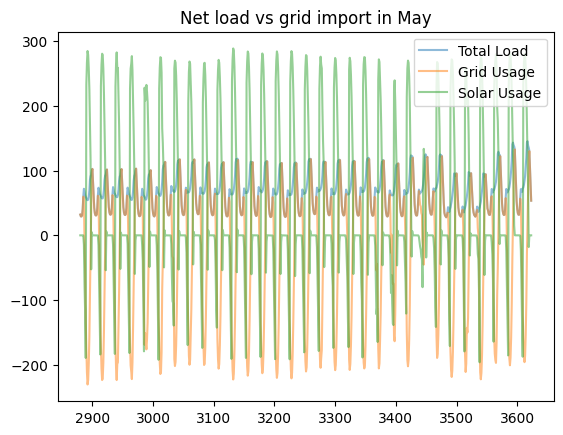

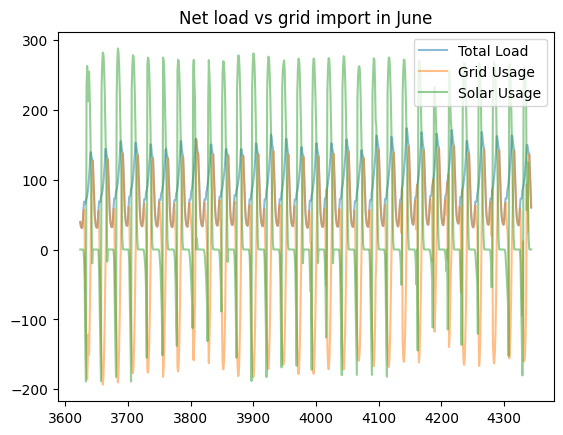

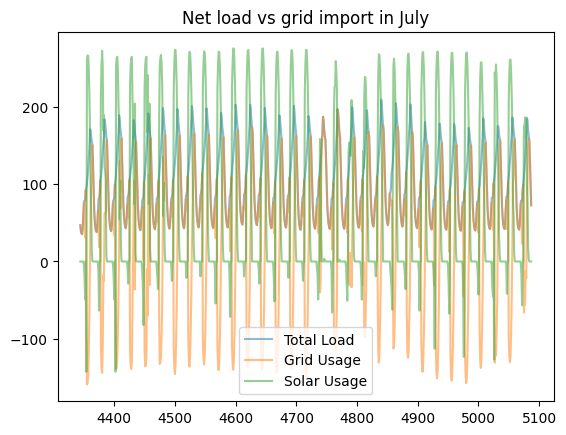

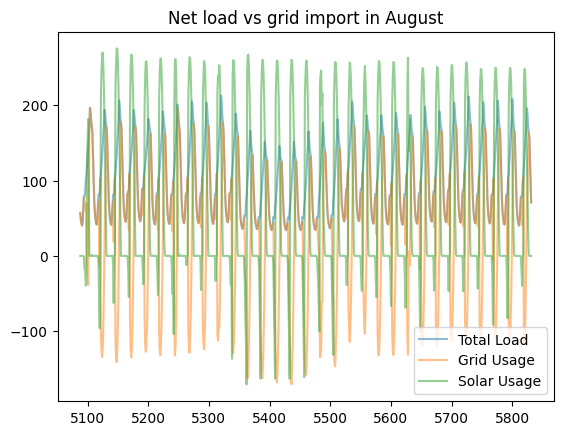

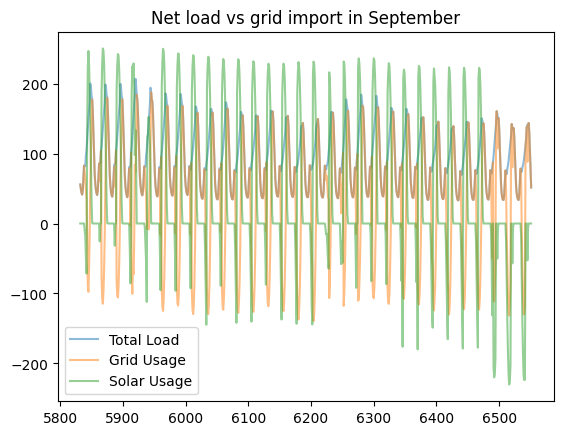

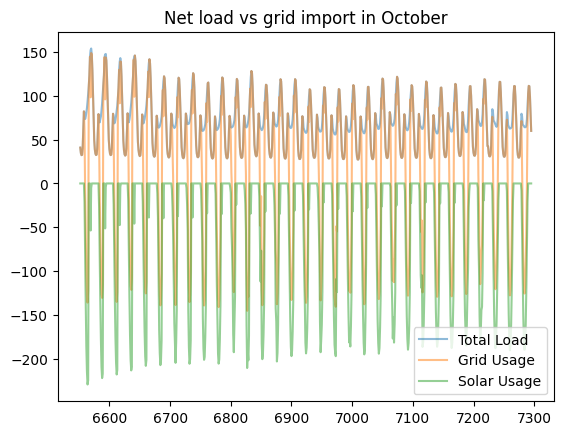

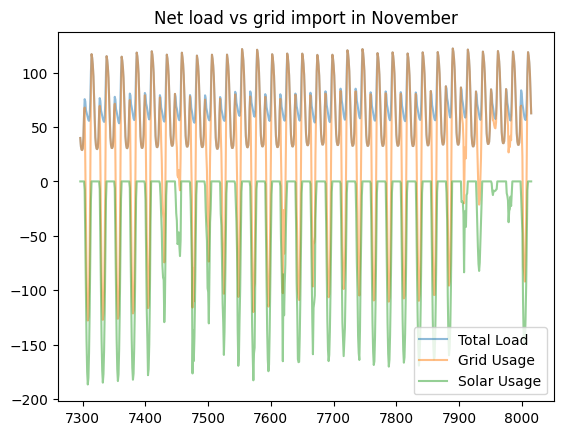

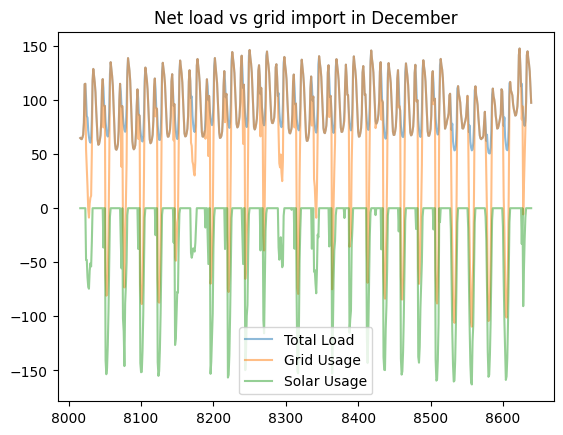

In [46]:
load = evaluation_grid_dqn.log[('load', 0, 'load_met')]
grid_usage = grid_import - grid_export
solar_state = solar_use - solar_sell

for month, (start_hour, end_hour) in month_start_end_dates.items():

    pd.concat([load, grid_usage, solar_state],
              keys=['Total Load', 'Grid Usage', "Solar Usage"],
              axis=1).iloc[start_hour:end_hour].plot(alpha=0.5, title=f'Net load vs grid import in {month}')

    plt.show()

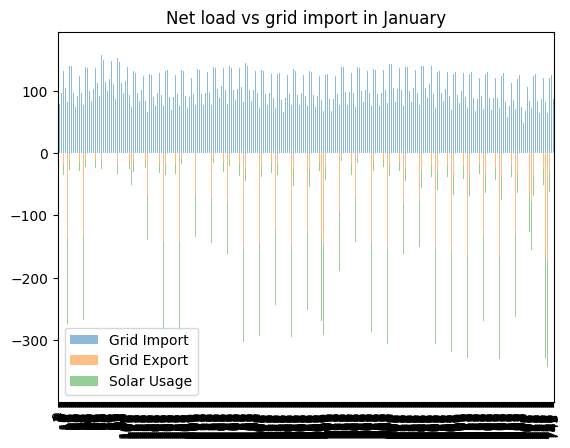

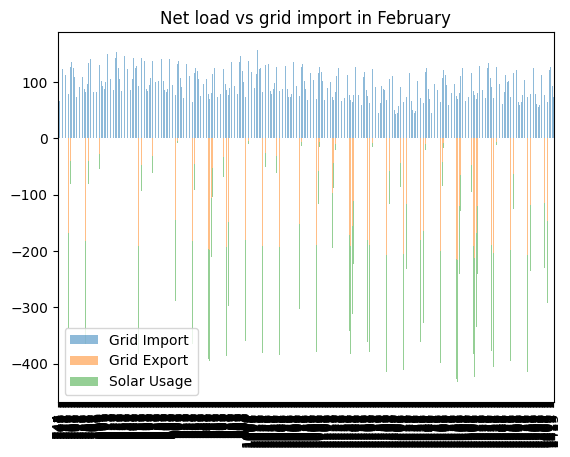

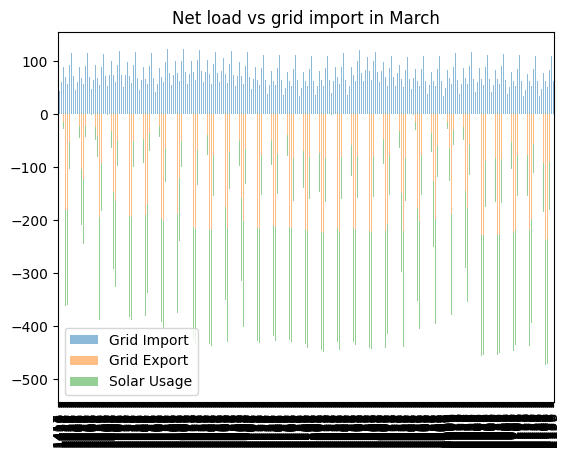

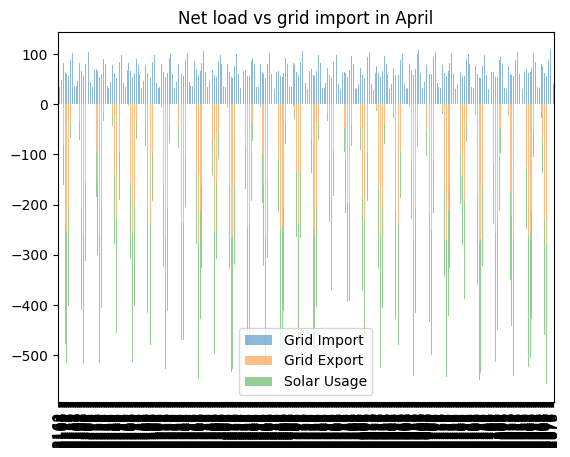

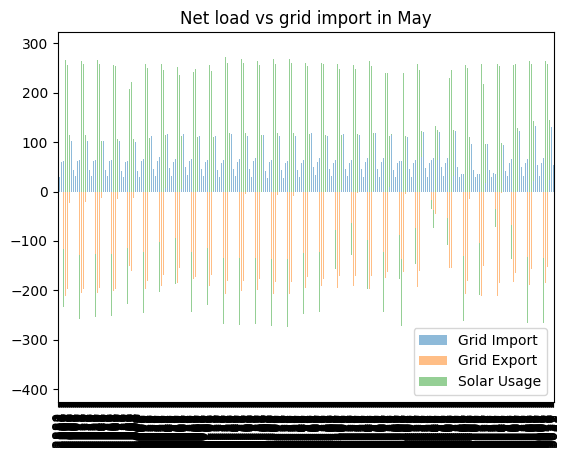

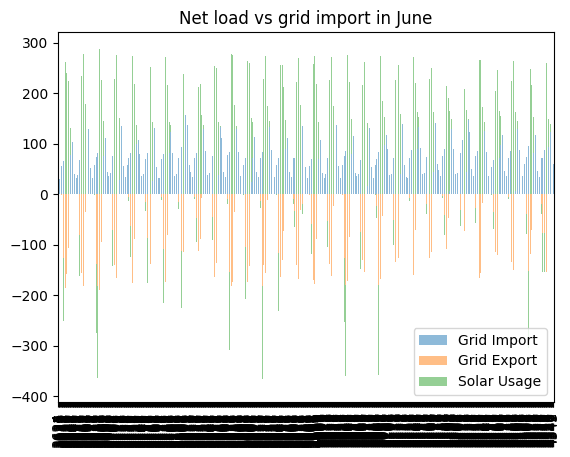

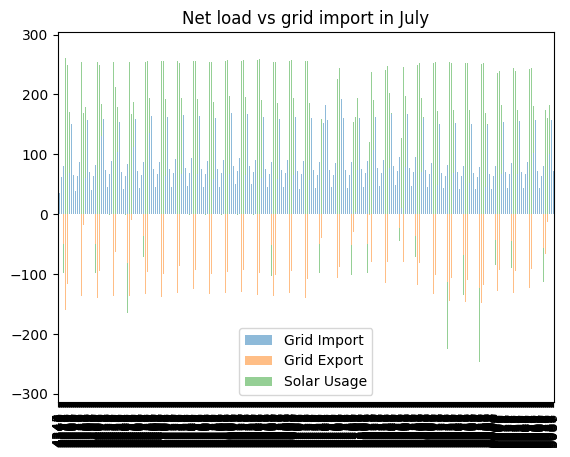

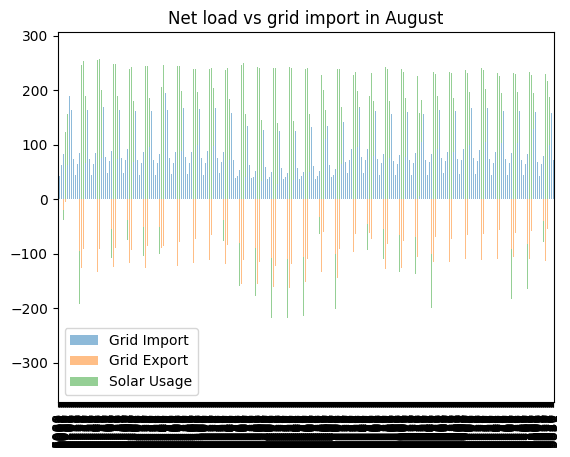

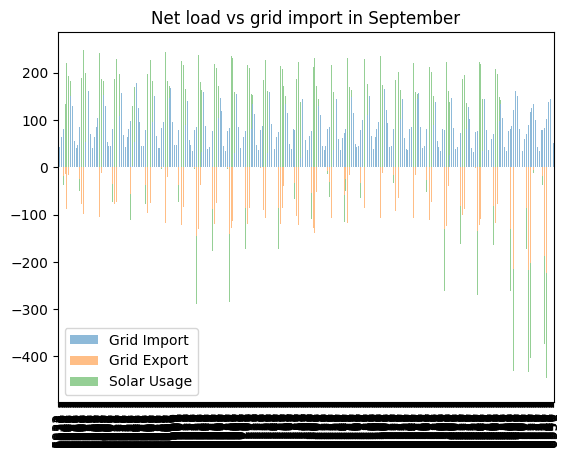

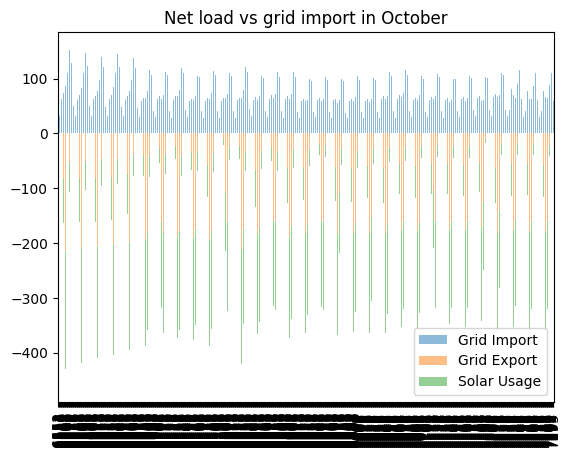

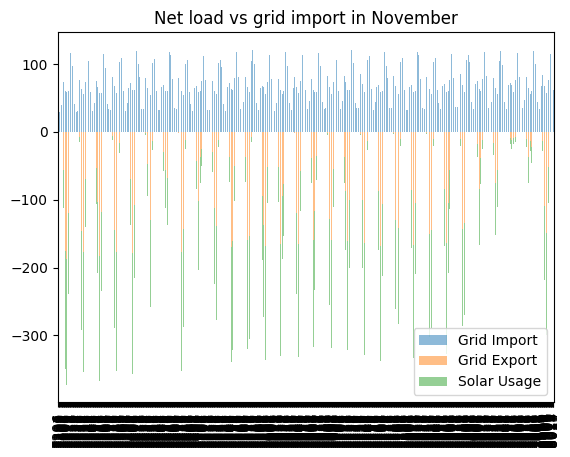

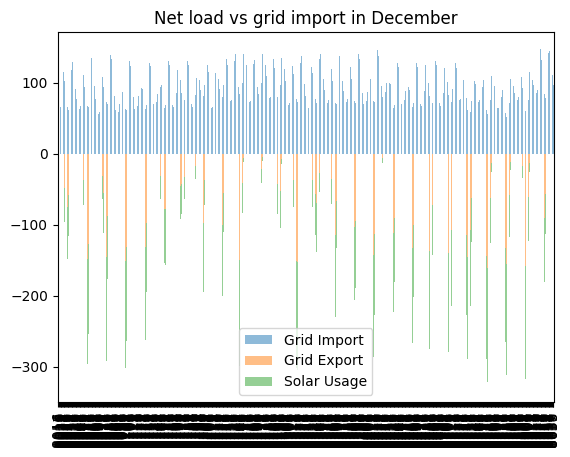

In [47]:
load = evaluation_grid_dqn.log[('load', 0, 'load_met')]
grid_usage = grid_import - grid_export
solar_state = solar_use - solar_sell

for month, (start_hour, end_hour) in month_start_end_dates.items():

    pd.concat([grid_import, -grid_export, solar_state],
              keys=['Grid Import', "Grid Export", "Solar Usage"],
              axis=1).iloc[start_hour:end_hour].plot(kind="bar", stacked=True, alpha=0.5, title=f'Net load vs grid import in {month}')

    plt.show()

In [49]:
day_grid_import = np.zeros(365)
day_grid_export = np.zeros(365)
day_solar_state = np.zeros(365)
for i in range(365):
    day_grid_import[i] = grid_import[i*24:(i+1)*24].sum()
    day_grid_export[i] = grid_export[i*24:(i+1)*24].sum()
    day_solar_state[i] = solar_state[i*24:(i+1)*24].sum()

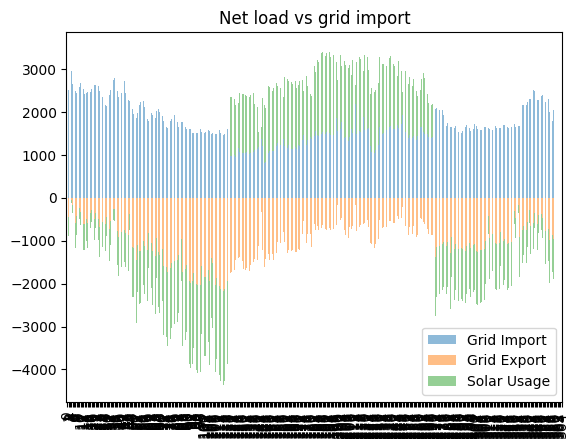

In [50]:
day_grid_import = pd.Series(day_grid_import)
day_grid_export = pd.Series(day_grid_export)
day_solar_state = pd.Series(day_solar_state)

pd.concat([day_grid_import, -day_grid_export, day_solar_state],
          keys=['Grid Import', "Grid Export", "Solar Usage"],
          axis=1).plot(kind="bar", stacked=True, alpha=0.5, title=f'Net load vs grid import')

plt.show()

<Axes: >

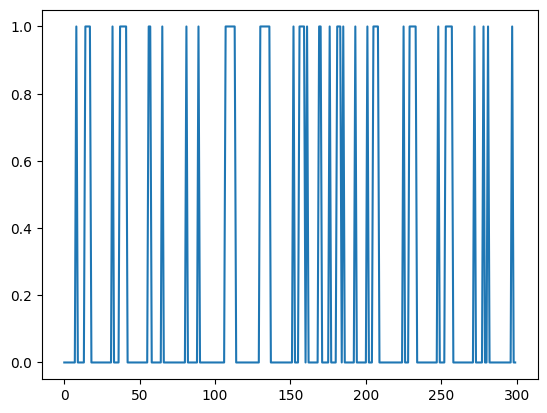

In [38]:
solar_status[:300].plot()

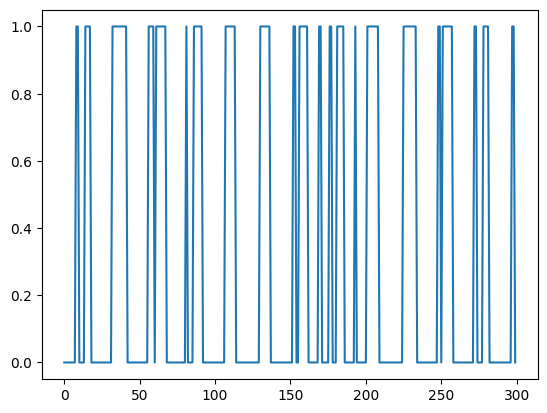

In [40]:
plt.plot(solar_usage[:300])